<a href="https://colab.research.google.com/github/HD666g/NTHU_2023_DLBOI_HW/blob/main/Report/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [28]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

batch_size = 32

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


### No Data augmentation

In [34]:
# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


### Data Augmentation

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

class useDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]
        img = np.array(img, dtype=np.uint8)

        img = Image.fromarray(img.transpose(1, 2, 0))

        if self.transform:
            img = self.transform(img)

        return img, self.y[idx]

# Create Datasets
train_dataset = useDataset(x_train, y_train, train_transforms)
val_dataset = useDataset(x_val, y_val, val_transforms)

# Create Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

## Visualize Dataset

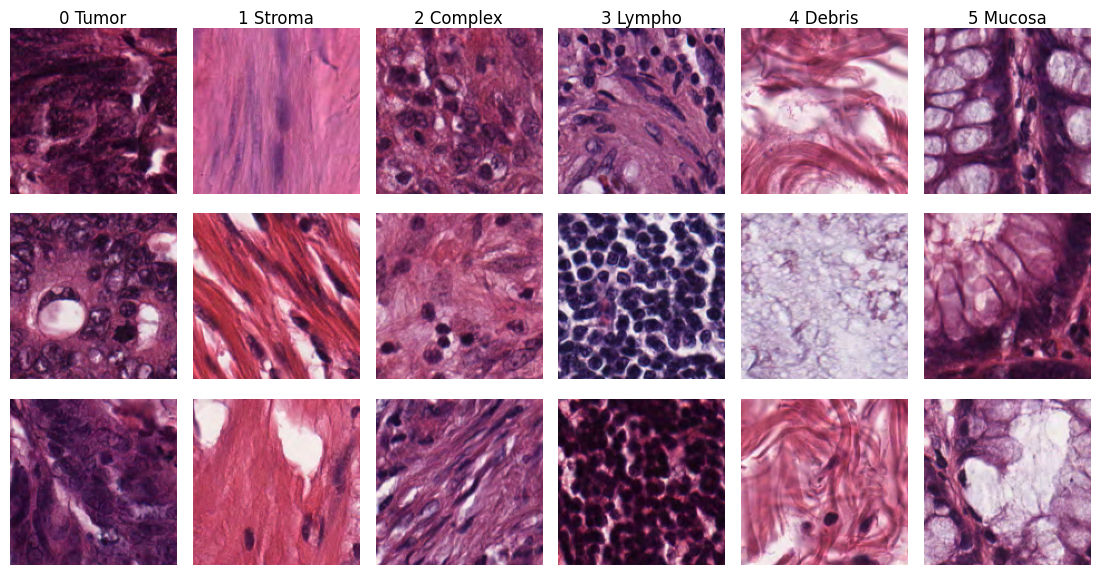

In [42]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0)) #numpy().transpose(1, 2, 0) for no data augmentation;
        img = img / img.max()
        ax.imshow(img) # transpose(1, 2, 0) for data augmentation
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

## B. Defining Neural Networks

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from collections import namedtuple

# Handcraft ResNet
class ResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)

        else:
            downsample = None
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
           identity = x
           x = self.conv1(x)
           x = self.conv2(x)
           x = self.conv3(x)

           if self.downsample is not None:
              identity = self.downsample(identity)

           _, _, h, w = x.size()
           identity = F.pad(identity, (0, w - identity.size(3), 0, h - identity.size(2)))

           x += identity
           x = self.relu(x)
           return x

class ResNet(nn.Module):
    def __init__(self, config, output_dim):
      super().__init__()

      block, n_blocks, channels = config._asdict()['block'], config.n_blocks, config.channels
      self.in_channels = channels[0]

      assert len(n_blocks) == len(channels) == 4

      self.pre_layer = nn.Sequential(
          nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
          nn.BatchNorm2d(self.in_channels),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      )

      self.layer1 = self.make_layers(block, n_blocks[0], channels[0])
      self.layer2 = self.make_layers(block, n_blocks[1], channels[1], stride=2)
      self.layer3 = self.make_layers(block, n_blocks[2], channels[2], stride=2)
      self.layer4 = self.make_layers(block, n_blocks[3], channels[3], stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.fc = nn.Linear(self.in_channels, output_dim)

    def make_layers(self, block, n_blocks, channels, stride=1):
      layers = []
      if self.in_channels != block.expansion * channels:
        downsample = True
      else:
        downsample = False

      layers.append(block(self.in_channels, channels, stride, downsample))

      for i in range(1, n_blocks):
        layers.append(block(block.expansion * channels, channels))

      self.in_channels = block.expansion * channels

      return nn.Sequential(*layers)

    def forward(self, x):

      x = self.pre_layer(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      h = x.view(x.shape[0], -1)
      x = self.fc(h)

      return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet50_config = ResNetConfig(block=ResidualBlock,n_blocks=[3,4,6,3],channels=[64,128,256,512])

In [44]:
# Convolutional Network
class ConvModel(nn.Module):
  def __init__(self):
      super().__init__()

      self.net = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same'),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 64, kernel_size=7, stride=1, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=7, stride=1, padding='same'),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(128, 64, kernel_size=5, stride=1, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          nn.Linear(64, num_classes)
      )
  def forward(self, x):
      x = self.net(x)
      return x

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
import copy

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# model = ResNet(resnet50_config, output_dim=6)
model = ConvModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # CheckPoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}， Valacc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f}, Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

ConvModel(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (15)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 1.0501, Train acc: 61.96%, Val loss: 0.9424， Valacc: 64.50%, Best Val loss: 0.9424, Best Val acc: 64.50%
Epoch 2/30, Train loss: 0.7431, Train acc: 73.84%, Val loss: 0.7160， Valacc: 74.83%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 3/30, Train loss: 0.6390, Train acc: 77.65%, Val loss: 1.1608， Valacc: 65.17%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 4/30, Train loss: 0.5897, Train acc: 78.63%, Val loss: 1.0036， Valacc: 65.17%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 5/30, Train loss: 0.5562, Train acc: 81.18%, Val loss: 0.8684， Valacc: 67.83%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 6/30, Train loss: 0.5249, Train acc: 80.63%, Val loss: 0.9243， Valacc: 68.50%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 7/30, Train loss: 0.4626, Train acc: 83.18%, Val loss: 1.2046， Valacc: 71.83%, Best Val loss: 0.7160, Best Val acc: 74.83%
Epoch 8/30, Train loss: 0.4462, Train acc: 84.08%, Val loss: 0.5243， Valacc: 81.33%, Best Val los

### Visualizing model performance

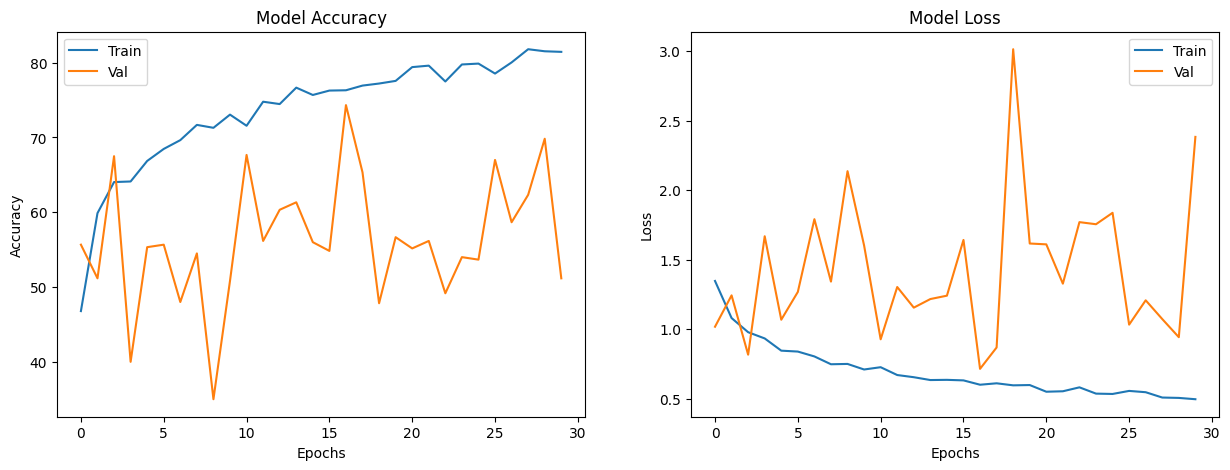

In [23]:
import matplotlib.pyplot as plt
from google.colab import files
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])


# plt.savefig('8_train_conv_oaug.png')
# files.download('8_train_conv_oaug.png')
plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [13]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [24]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 3

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [25]:
# model = ResNet('resnet50_config', output_dim=6)
# model = ConvModel()
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
      for images, labels in tqdm(test_loader):

          # The two lines of codes used with no data augmentation
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)

          predicted = outputs.argmax(-1)

          test_correct += (predicted.float() == labels).sum().item() # float() goes with no data augmentation
          test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/200 [00:00<?, ?it/s]

Test accuracy is 22.0%
